# Deep dive into RAG Evaluation

In this notebook, we'll show you how to evaluate the output of a RAG system. The high-level RAG flow is depicted in the diagram below.
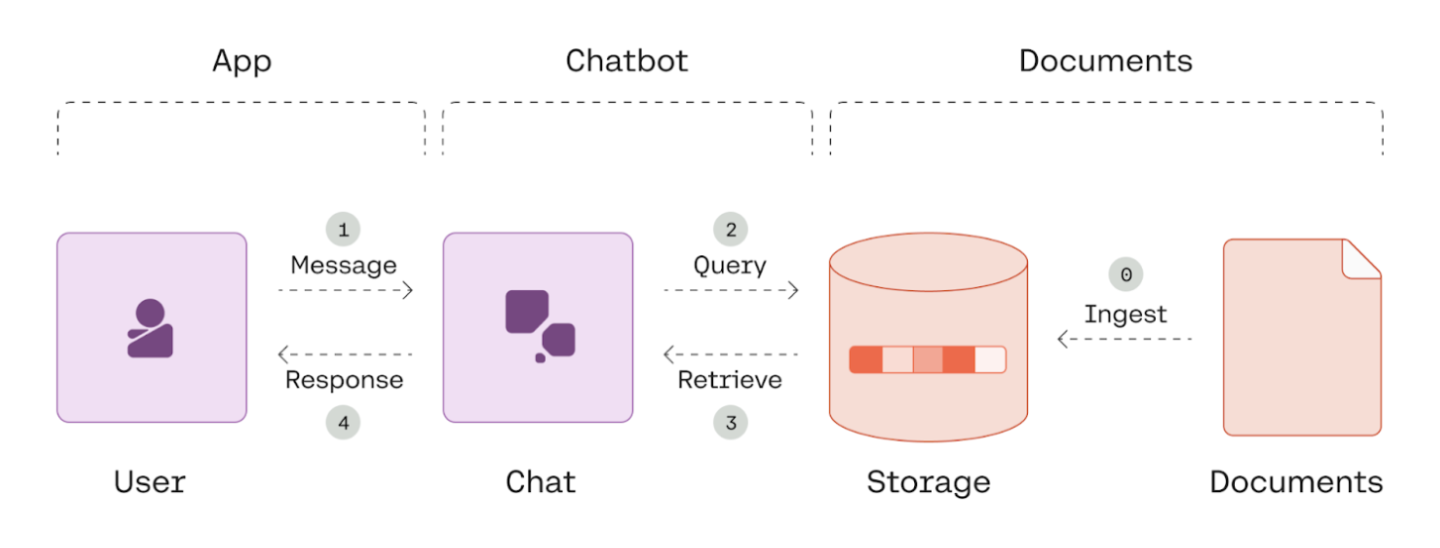

We will focus on the evaluation of **Retrive** and **Response** (or **Generation**), and present a set of metrics for each phase. We will deep dive into each metric, to give you a full understanding of how we evaluate models and why we do it this way, and provide code so you can repdroduce on your own data.

To demonstrate the metrics, we will use data from the [Docugami's KG-RAG](https://github.com/docugami/KG-RAG-datasets/tree/main/sec-10-q/data/v1) dataset, a RAG dataset for financial 10Q filing reports. We will focus only on evaluation, without performing the actual Retrieval and response Generation steps: for this, you can check out [this great blogpost](https://colab.research.google.com/drive/194hYnKZXhgwvJSlSoBD4850Iwia3cCZ6#scrollTo=88jSFwI-5YCN)!

# Table of content

1. [Getting started](#getting-started)
2. [Retrieval Evaluation](#retrieval-evaluation)
3. [Generation Evaluation](#generation-evaluation)
4. [Final Comments](#final-comments)

<a name="getting-started"></a>
## Getting Started

Let's start by setting the environment and downloading the dataset.

In [ ]:
%%capture
!pip install llama-index cohere openai
!pip install mistralai

In [ ]:
# required imports
import cohere
from getpass import getpass
import os
import re
import json
import numpy as np
import pandas as pd
from llama_index.core import SimpleDirectoryReader
from llama_index.core.llama_dataset import download_llama_dataset, LabelledRagDataset
from openai import Client
from mistralai.client import MistralClient

For Response evaluation, we will use an LLM as a judge.
Any LLM can be used for this goal, but because evaluation is a very challenging task, we recommend using powerful LLMs, possibly as an ensemble of models. In [previous work](https://arxiv.org/pdf/2303.16634.pdf), it has been shown that models tend to assign higher scores to their own output. Since we generated the answers in this notebook using `command-r`, we will not use it for evaluation. We will provide two alternatives, `gpt-4` and `mistral`. We set `gpt-4` as the default model because, as mentioned above, evaluation is challenging, and `gpt-4` is powerful enough to efficiently perform the task.

In [ ]:
# Get keys
openai_api_key = getpass("Enter your OpenAI API Key: ")
# uncomment if you want to use mistral
#mistral_api_key = getpass["Enter your Mistral API Key: "]

# Define the model you want to use - you can replace gpt-4 with any other gpt version
model = "gpt-4"
# uncomment if you want to use mistral
#model = "mistral-large-latest"


Enter your OpenAI API Key: ··········


In [ ]:
if model == "gpt-4":
  client = Client(api_key=openai_api_key)
else:
  client = MistralClient(api_key=mistral_api_key)

In [ ]:
# let's define a function to get the model's response for a given input
def get_response(model, client, prompt):
  response = client.chat.completions.create(
      model=model,
      messages=[{"role": "user", "content": prompt}],
      temperature=0)
  return response.choices[0].message.content

In [ ]:
# load the DocugamiKgRagSec10Q dataset
if os.path.exists("./data/source_files") and os.path.exists("./data/rag_dataset.json"):
        rag_dataset = LabelledRagDataset.from_json("./data/rag_dataset.json")
        documents = SimpleDirectoryReader(input_dir="./data/source_files").load_data(show_progress=True)
else:
    rag_dataset, documents = download_llama_dataset("DocugamiKgRagSec10Q", "./data")

Loading files: 100%|██████████| 20/20 [01:44<00:00,  5.21s/file]


<a name="retrieval-evaluation"></a>
## Retrieval Evaluation

In the Retrieval phase, we evaluate the set of **retrieved documents** against the **golden documents** set.

We use three standard metrics to evaluate retrieval:

*   **Precision**: the proportion of returned documents that are relevant, according to the gold annotation
*   **Recall**: the proportion of relevant documents in the gold data found in the retrieved documents
*   **Mean Average Precision** (**MAP**): measures the capability of the retriever to return relevant documents at the top of the list

We implement these three metrics in the class below:

In [ ]:
class RetrievalEvaluator:

    def compute_precision(self, retrieved_documents, golden_documents):
      # compute the percentage of retrieved documents found in the golden docs
      return len(set(retrieved_documents).intersection(golden_documents)) / len(retrieved_documents)

    def compute_recall(self, retrieved_documents, golden_documents):
      # compute the percentage of golden documents found in the retrieved docs
      return len(set(retrieved_documents).intersection(golden_documents)) / len(golden_documents)

    def compute_mean_average_precision(self, retrieved_documents, golden_documents):
      # check which among the retrieved docs is found in the gold, keeping the order
      correct_retrieved_documents = [1 if x in golden_documents else 0 for x in retrieved_documents]
      # compute map
      map = np.mean([sum(correct_retrieved_documents[: i + 1]) / (i + 1) for i, v in enumerate(correct_retrieved_documents) if v == 1])
      return map

    def run_evals(self, retrieved_documents, golden_documents):
      precision = round(self.compute_precision(retrieved_documents, golden_documents),2)
      recall = round(self.compute_recall(retrieved_documents, golden_documents),2)
      map = round(self.compute_mean_average_precision(retrieved_documents, golden_documents),2)
      results = {'precision': [precision],
                 'recall': [recall],
                 'map': [map]}
      results = pd.DataFrame(results)
      return results



Let's now see how to use the class above to compute the results on a single datapoint.

In [ ]:
# select the index of a single datapoint - the first one in the dataset
idx = 0

# select the query
query = rag_dataset[idx].query

# and the golden docs
golden_docs = rag_dataset[idx].reference_answer.split('SOURCE(S): ')[1].split(', ')

# let's assume we have the following set of retrieved docs
retrieved_docs = ['2022 Q3 AAPL.pdf', '2023 Q1 MSFT.pdf', '2023 Q1 AAPL.pdf']

print(f'Query: {query}')
print(f'Golden docs: {golden_docs}')
print(f'Retrieved docs: {retrieved_docs}')

Query: How has Apple's total net sales changed over time?
Golden docs: ['2022 Q3 AAPL.pdf', '2023 Q1 AAPL.pdf', '2023 Q2 AAPL.pdf', '2023 Q3 AAPL.pdf']
Retrieved docs: ['2022 Q3 AAPL.pdf', '2023 Q1 MSFT.pdf', '2023 Q1 AAPL.pdf']


In [ ]:
# we can now instantiate the evaluator
evaluate_retrieval = RetrievalEvaluator()

# and run the evaluation
evaluate_retrieval.run_evals(retrieved_docs,golden_docs)


,precision,recall,map
0,0.67,0.5,0.83


What are the figures above telling us?

*   Precision (0.67) tells us that 2 out of 3 of the retrieved docs are correct
*   Recall (0.5) means that 2 out of 4 relevant docs have been retrieved
*   MAP (0.83) is computed as the average of 1/1 (the highest ranked doc is correct) and 2/3 (the 2nd ranked doc is wrong, the 3rd is correct).

While the example here focuses on a single datapoint, you can easily apply the same metrics to all your dataset and get the overall performance of your Retrieve phase.

<a name="generation-evaluation"></a>
## Generation Evaluation

Evaluating grounded generation (the second step of RAG) is notoriously difficult, because generations are usually complex and rich of information, and simply labelling an answer as "good" or "bad" is not enough.
To overcome this issue, we first decompose complex answers into a set of basic *claims*, where a claim is any sentence or part of a sentence in the answer that expresses a verifiable fact. Subsequently, we check the validity of each claim independently, defining the overall quality of the answer based on the correctness of the claims it includes.

We use claims to compute three metrics:

*   **Faithfulness**, which measures how many of the claims in the generated response are supported by the retrieved documents. This is a fundamental metric, as it tells us how *grounded* in the documents the response is, and, contextually, it allows us to spot hallucinations

*   **Correctness**, which checks which claims in the response also occur in the gold answer

*   And **Coverage**, by which we assess how many of the claims in the gold answer are included in the generated response.

Note that Faithfulness and Correctness share the exact same approach, the difference being that the former checks the claims against the supporting docs, while the latter against the golden answer.
Also, while Correctness is measuring the precision of the claims in the response, Coverage can be seen as complementary, as it measures recall.

### Claim Extraction

Let's now see how we implement the evaluation described above using LLMs. Let's start with **claim extraction**.

In [ ]:
# first, let's define a function which extracts the claims from a response
def extract_claims(query, response, model, client):

  # define the instructions on how to extract the claims
  preamble = "You are shown a prompt and a completion. You have to identify the main claims stated in the completion. A claim is any sentence or part of a sentence that expresses a verifiable fact. Please return a bullet list, in which every line includes one of the claims you identified. Do not add any further explanation to the bullet points."

  # build the prompt
  prompt = f"{preamble}\n\nPROMPT: {query}\n\nCOMPLETION: {response}"

  # get the claims
  claims = get_response(model, client, prompt)

  return claims


In [ ]:
# now, let's consider this answer, which we previously generated with command-r
response = "Apple's total net sales experienced a decline over the last year. The three-month period ended July 1, 2023, saw a total net sale of $81,797 million, which was a 1% decrease from the same period in 2022. The nine-month period ended July 1, 2023, fared slightly better, with a 3% decrease in net sales compared to the first nine months of 2022.\nThis downward trend continued into the three and six-month periods ending April 1, 2023. Apple's total net sales decreased by 3% and 4% respectively, compared to the same periods in 2022."

# let's extract the claims
claims = extract_claims(query, response, model, client)

# and see what the model returns
print(f"List of claims extracted from the model's response:\n\n{claims}")

List of claims extracted from the model's response:

- Apple's total net sales experienced a decline over the last year.
- The three-month period ended July 1, 2023, saw a total net sale of $81,797 million.
- This was a 1% decrease from the same period in 2022.
- The nine-month period ended July 1, 2023, had a 3% decrease in net sales compared to the first nine months of 2022.
- The downward trend continued into the three and six-month periods ending April 1, 2023.
- Apple's total net sales decreased by 3% and 4% respectively, compared to the same periods in 2022.


### Claim Assessment

Nice! now that we have the list of claims, we can go ahead and **assess the validity** of each claim.

In [ ]:
# Let's create a function that checks each claim against a reference text,
# which here we will call "context". As you will see, we will use different contexts,
# depending on the metric we want to compute.

def assess_claims(query, claims, context, model, client):

  # define the instructions on how to perform the assessment.
  # the model has to append to each row a binary SUPPORTED tag
  preamble = "You are shown a prompt, a context and a list of claims. You have to check which of the claims in the list are supported by the context. Please return the list of claims exactly as is it, just append to each row “SUPPORTED=1” if the claim is supported by the context, or “SUPPORTED=0” if the claim is not supported by the context. Do not add any further explanation to the bullet points."

  # turn list into string
  context = '\n'.join(context)

  # build the prompt
  prompt = f"{preamble}\n\nPROMPT: {query}\n\nCONTEXT:\n{context}\n\nCLAIMS:\n{claims}"

  # get the response
  assessment = get_response(model, client, prompt)

  return assessment

### Faithfulness

In [ ]:
# Let's start with Faithfulness: in this case, we want to assess the claims
# in the response against the retrieved documents (i.e., context = retrieved documents)

# for the sake of clarity, we report the actual text of the retrieved documents
retrieved_documents = ['Products and Services Performance\nThe following table shows net sales by category for the three- and six-month periods ended April 1, 2023 and March 26, 2022 (dollars in millions):\nThree Months Ended Six Months Ended\nApril 1,\n2023March 26,\n2022 ChangeApril 1,\n2023March 26,\n2022 Change\nNet sales by category:\niPhone $ 51,334 $ 50,570 2 %$ 117,109 $ 122,198 (4)%\nMac 7,168 10,435 (31)% 14,903 21,287 (30)%\niPad 6,670 7,646 (13)% 16,066 14,894 8 %\nWearables, Home and Accessories 8,757 8,806 (1)% 22,239 23,507 (5)%\nServices 20,907 19,821 5 % 41,673 39,337 6 %\nTotal net sales $ 94,836 $ 97,278 (3)%$ 211,990 $ 221,223 (4)%\niPhone\niPhone net sales were relatively flat during the second quarter of 2023 compared to the secon d quarter of 2022. Year-over-year iPhone net sales decreased\nduring the first six months of 2023 due primarily to lower net sales from the Company’ s new iPhone models launched in the fourth quarter of 2022.\nMac\nMac net sales decreased during the second quarter and first six months of 2023 compared to the same periods in 2022 due primarily to lower net sales of\nMacBook Pro.\niPad\niPad net sales decreased during the second quarter of 2023 compared to the second quarter of 2022 due primarily to lower net sales of iPad Pro  and iPad Air.\nYear-over-year iPad net sales increased during the first six months of 2023 due primarily to higher net sales of iPad, partially offset by lower net sales of iPad\nmini .\nWearables, Home and Accessories\nWearables, Home and Accessories net sales were relatively flat during the second quarter of 2023 compared to the second quarter of 2022. Year-over-year\nWearables, Home and Accessories net sales decreased during the first six months of 2023 due primarily to lower net sales of AirPods .\nServices\nServices net sales increased during the second quarter and first six months of 2023 compared to the same periods in 2022 due primarily to higher net sales from\ncloud services, music and advertising.® ®\n®\n®\nApple Inc. | Q2 2023 Form 10-Q | 16', 'Products and Services Performance\nThe following table shows net sales by category for the three- and nine-month periods ended July 1, 2023 and June 25, 2022 (dollars in millions):\nThree Months Ended Nine Months Ended\nJuly 1,\n2023June 25,\n2022 ChangeJuly 1,\n2023June 25,\n2022 Change\nNet sales by category:\niPhone $ 39,669 $ 40,665 (2)%$ 156,778 $ 162,863 (4)%\nMac 6,840 7,382 (7)% 21,743 28,669 (24)%\niPad 5,791 7,224 (20)% 21,857 22,118 (1)%\nWearables, Home and Accessories 8,284 8,084 2 % 30,523 31,591 (3)%\nServices 21,213 19,604 8 % 62,886 58,941 7 %\nTotal net sales $ 81,797 $ 82,959 (1)%$ 293,787 $ 304,182 (3)%\niPhone\niPhone net sales decreased during the third quarter and first nine months of 2023 compared to the same periods in 2022 due primarily to lower net sales from\ncertain iPhone models, partially of fset by higher net sales of iPhone 14 Pro models.\nMac\nMac net sales decreased during the third quarter and first nine months of 2023 compared to the same periods in 2022 due primarily to lower net sales of laptops.\niPad\niPad net sales decreased during the third quarter of 2023 compared to the third quarter of 2022 due primarily to lower net sales across most iPad models. Year-\nover-year iPad net sales were relatively flat during the first nine months of 2023.\nWearables, Home and Accessories\nWearables, Home and Accessories net sales increased during the third quarter of 2023 compare d to the third quarter of 2022 due primarily to higher net sales of\nWearables, which includes AirPods , Apple Watch  and Beats  products, partially offset by lower net sales of accessories. Year-over-year Wearables, Home\nand Accessories net sales decreased during the first nine months of 2023 due primarily to lower net sales of W earables and accessories.\nServices\nServices net sales increased during the third quarter of 2023 compared to the third quarter of 2022 due primarily to higher net sales from advertising, cloud\nservices and the App Store . Year-over-year Services net sales increased during the first nine months of 2023 due primarily to higher net sales from cloud\nservices, advertising and music.® ® ®\n®\nApple Inc. | Q3 2023 Form 10-Q | 16']

# get the Faithfulness assessment for each claim
assessed_claims_faithfulness = assess_claims(query=query,
                                             claims=claims,
                                             context=retrieved_documents,
                                             model=model,
                                             client=client)

print(f"Assessment of the claims extracted from the model's response:\n\n{assessed_claims_faithfulness}")

Assessment of the claims extracted from the model's response:

- Apple's total net sales experienced a decline over the last year. SUPPORTED=1
- The three-month period ended July 1, 2023, saw a total net sale of $81,797 million. SUPPORTED=1
- This was a 1% decrease from the same period in 2022. SUPPORTED=1
- The nine-month period ended July 1, 2023, had a 3% decrease in net sales compared to the first nine months of 2022. SUPPORTED=1
- The downward trend continued into the three and six-month periods ending April 1, 2023. SUPPORTED=1
- Apple's total net sales decreased by 3% and 4% respectively, compared to the same periods in 2022. SUPPORTED=1


Great, we now have an assessment for each of the claims: in the last step, we just need to use these assessments to define the final score.

In [ ]:
# given the list of claims and their label, compute the final score
# as the proportion of correct claims over the full list of claims
def get_final_score(claims_list):
  supported = len(re.findall("SUPPORTED=1", claims_list))
  non_supported = len(re.findall("SUPPORTED=0", claims_list))
  score = supported / (supported+non_supported)
  return round(score, 2)

In [ ]:
score_faithfulness = get_final_score(assessed_claims_faithfulness)
print(f'Faithfulness: {score_faithfulness}')

Faithfulness: 1.0


The final Faithfulness score is 1, which means that the model's response is fully grounded in the retrieved documents: that's a very good news :)

Before moving on, let's modify the model's response by adding a piece of information which is **not** grounded in any document, and re-compute Faithfulness.

In [ ]:
# let's mess up the century, changing 2022 to 1922
modified_response = response.replace('2022', '1922')

# extract the claims from the modified response
modified_claims = extract_claims(query, modified_response, model, client)

# and get assess the modified claims
assessed_modified_claims = assess_claims(query=query,
                                         claims=modified_claims,
                                         context=retrieved_documents,
                                         model=model,
                                         client=client)

print(f"Assessment of the modified claims:\n\n{assessed_modified_claims}\n")

score_faithfulness_modified_claims = get_final_score(assessed_modified_claims)
print(f'Faithfulness: {score_faithfulness_modified_claims}')

Assessment of the modified claims:

- Apple's total net sales experienced a decline over the last year. SUPPORTED=1
- The three-month period ended July 1, 2023, saw a total net sale of $81,797 million. SUPPORTED=1
- This was a 1% decrease from the same period in 1922. SUPPORTED=0
- The nine-month period ended July 1, 2023, had a 3% decrease in net sales compared to the first nine months of 1922. SUPPORTED=0
- The downward trend continued into the three and six-month periods ending April 1, 2023. SUPPORTED=1
- Apple's total net sales decreased by 3% and 4% respectively, compared to the same periods in 1922. SUPPORTED=0

Faithfulness: 0.5


As you can see, by assessing claims one by one, we are able to spot **hallucinations**, that is, the (corrupted) cases in which the information provided by the model is not grounded in any of the retrieved documents.

### Correctness

As said, Faithfulness and Correctness share the same logic, the only difference being that we will check the claims against the gold answer. We can therefore repeat the process above, and just substitute the `context`.

In [ ]:
# let's get the gold answer from the dataset
golden_answer = rag_dataset[idx].reference_answer

# and check the claims in the response against the gold.
# note that assess_claims takes exactly the same args as with Faithfulness
# except for the context, that now is the golden_answer
assessed_claims_correctness = assess_claims(query=query,
                                            claims=claims,
                                            context=golden_answer, # note the different context
                                            model=model,
                                            client=client)


print(f"Assess the claims extracted from the model's response against the golden answer:\n\n{assessed_claims_correctness}")

Assess the claims extracted from the model's response against the golden answer:

- Apple's total net sales experienced a decline over the last year. SUPPORTED=1
- The three-month period ended July 1, 2023, saw a total net sale of $81,797 million. SUPPORTED=1
- This was a 1% decrease from the same period in 2022. SUPPORTED=0
- The nine-month period ended July 1, 2023, had a 3% decrease in net sales compared to the first nine months of 2022. SUPPORTED=0
- The downward trend continued into the three and six-month periods ending April 1, 2023. SUPPORTED=1
- Apple's total net sales decreased by 3% and 4% respectively, compared to the same periods in 2022. SUPPORTED=0


As mentioned above, automatic evaluation is a hard task, and even when using powerful models, claim assessment can present problems: for example, the third claim is labelled as 0, even if it might be inferred from the information in the gold answer.

In [ ]:
# we can now compute the final Correctness score
score_correctness = get_final_score(assessed_claims_correctness)
print(f'Correctness: {score_correctness}')

Correctness: 0.5


For Correctness, we found that only half of the claims in the generated response are found in the gold answer. Note that this is not necessarily an issue: reference answers are often non-exhaustive, especially in dataset including open-ended questions, like the one we are considering in this post, and *both* the generated and golden answer can include relevant information.


### Coverage

We finally move to Coverage. Remember that, in this case, we want to check how many of the claims *in the gold answer* are included in the generated response. To do it, we first need to extract the claims from the gold answer.

In [ ]:
# let's extract the golden claims
gold_claims = extract_claims(query, golden_answer, model, client)

print(f"List of claims extracted from the gold answer:\n\n{gold_claims}")

List of claims extracted from the gold answer:

- For the quarterly period ended June 25, 2022, the total net sales were $82,959 million.
- For the quarterly period ended December 31, 2022, the total net sales were $117,154 million.
- For the quarterly period ended April 1, 2023, the total net sales were $94,836 million.
- For the quarterly period ended July 1, 2023, the total net sales were $81,797 million.
- There was an increase in total net sales from the quarter ended June 25, 2022, to the quarter ended December 31, 2022.
- There was a decrease in total net sales in the quarters ended April 1, 2023, and July 1, 2023.


Then, we check which of these claims is present in the response generated by the model.

In [ ]:
# note that in, this case, the context is the model's response
assessed_claims_coverage = assess_claims(query=query,
                                         claims=gold_claims,
                                         context=response,
                                         model=model,
                                         client=client)


print(f"Assess which of the gold claims is in the model's response:\n\n{assessed_claims_coverage}")

Assess which of the gold claims is in the model's response:

- For the quarterly period ended June 25, 2022, the total net sales were $82,959 million. SUPPORTED=0
- For the quarterly period ended December 31, 2022, the total net sales were $117,154 million. SUPPORTED=0
- For the quarterly period ended April 1, 2023, the total net sales were $94,836 million. SUPPORTED=0
- For the quarterly period ended July 1, 2023, the total net sales were $81,797 million. SUPPORTED=1
- There was an increase in total net sales from the quarter ended June 25, 2022, to the quarter ended December 31, 2022. SUPPORTED=0
- There was a decrease in total net sales in the quarters ended April 1, 2023, and July 1, 2023. SUPPORTED=1


In [ ]:
# we compute the final Coverage score
score_coverage = get_final_score(assessed_claims_coverage)
print(f'Coverage: {score_coverage}')

Coverage: 0.33


The Coverage score is telling us that 1/3 of the information in the gold answer is present in the generated answer. This is a useful information, that, similarly to what said above regarding Correctness, can raise further questions, such as: is it acceptable to have diverging information in the generated answer? Is any crucial piece of information missing in the generated answer?

The answer to these questions is use case-specific, and has to be made by the end user: The claim-based approach implemented here supports the user by providing a clear and detailed view on what the model is assessing and how.

<a name="final-comments"></a>
## Final Comments

RAG evaluation is a hard task, especially the evaluation of the generated response. In this notebook we offer a clear, robust and replicable approach to evaluation, on which you can build on to build your evaluation pipeline.